device used : cuda:0


/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


T : tensor(0.9999, device='cuda:0')  S : tensor(0.9764, device='cuda:0')
centre = (tensor(145), tensor(149)), r = 95 and the seg and ball have 293 pixels overlapping


/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


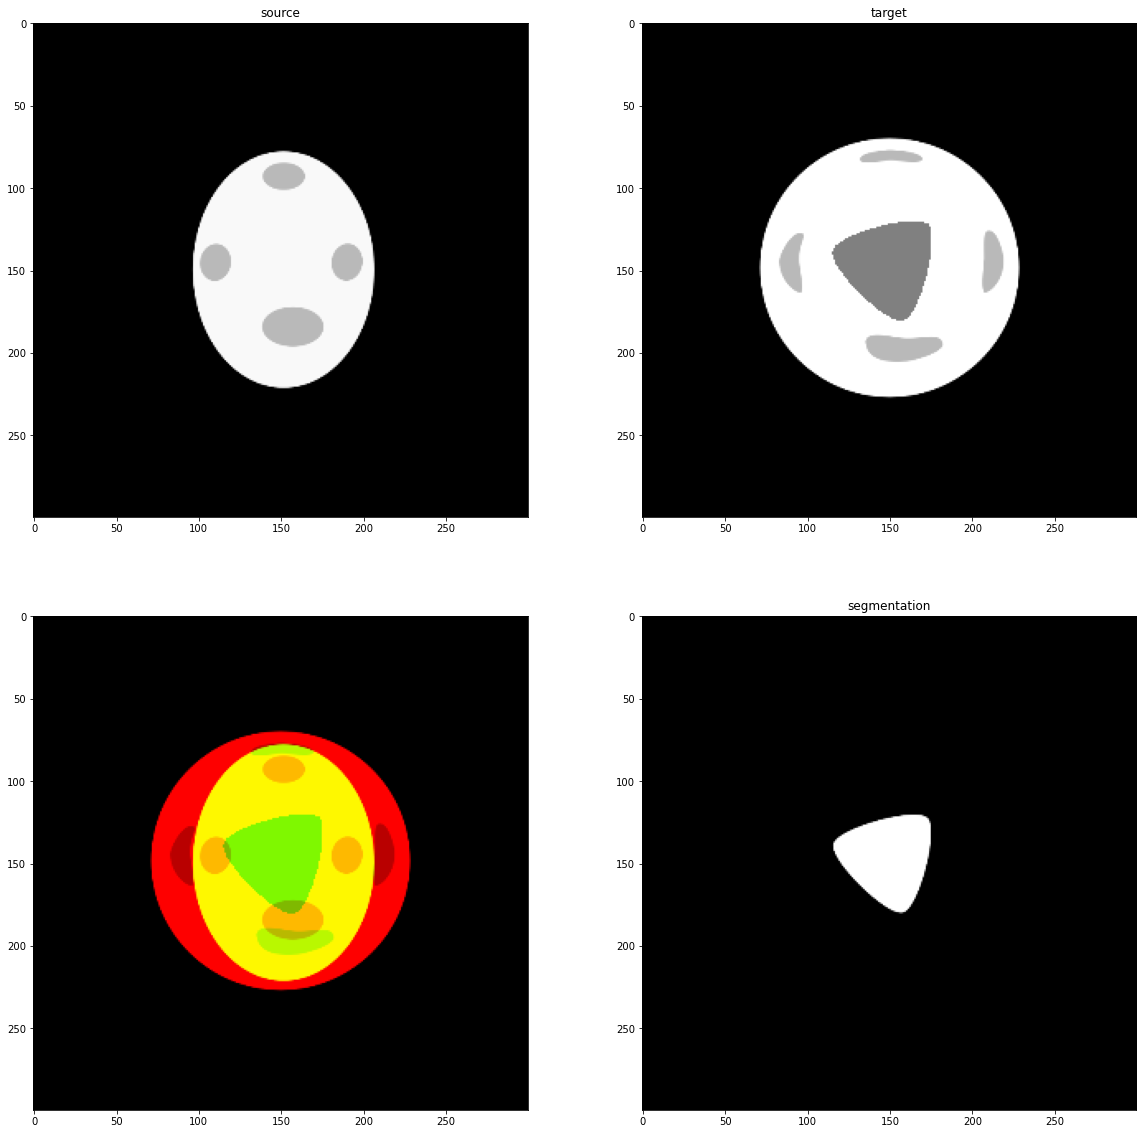

In [1]:
import os, sys, time
sys.path.append(os.path.abspath('../'))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
import torch

from my_toolbox import update_progress,format_time
%load_ext autoreload
%autoreload 2
import metamorphosis as mt
import my_torchbox as tb

cuda = torch.cuda.is_available()
device = 'cpu'
if cuda:
    device = 'cuda:0'
torch.autograd.set_detect_anomaly(False)
print('device used :',device)


size = (300,300)
source_name,target_name = '23','24'
S = tb.reg_open(source_name,size = size).to(device) #,location='bartlett')
T = tb.reg_open(target_name,size = size).to(device)
seg = tb.reg_open('21_seg',size=size).to(device)

#construct the target
if False:
    S = tb.addGrid2im(S,30,method='lines')
    T = tb.addGrid2im(T,30,method='lines')


if size is None:
    _,_,H,W = S.shape
    size = (H,W)
else:
    H,W = size


print('T :',T.max(),' S :',S.max())
## Construct the target image
ini_ball,_ = tb.make_ball_at_shape_center(seg,overlap_threshold=.1,verbose=True)
ini_ball = ini_ball.to(device)
T[seg>0] = 0.5

## Maintenant au boulot
source = S
target = T
# mask = mr.mp.image_stock

source_name = 'oval_w_round'
target_name = 'round_w_triangle_p_rd'

kw_img = dict(cmap='gray',vmin=0,vmax=1)
plt.rcParams["figure.figsize"] = (20,20)
fig,ax = plt.subplots(2,2)
ax[0,0].imshow(source[0,0,:,:].cpu().numpy(),**kw_img)
ax[0,0].set_title('source')
ax[0,1].imshow(target[0,0,:,:].cpu().numpy(),**kw_img)
ax[0,1].set_title('target')
ax[1,0].imshow(tb.imCmp(source,target),vmin=0,vmax=1)
ax[1,1].imshow(seg[0,0].cpu().numpy(),**kw_img)
ax[1,1].set_title('segmentation')
plt.show()

# 0./ How to read the plots
For each Experiments successives plots are showed :
 1. __Cost evolution__
    1. With relative coefficients, (i.e.: we plot $\rho \|z_0\|_{L^2}^2$)
    2. Raw values (i.e.: we plot $\|z_0\|_{L_2}^2$)
 2. __Visualisation of the method end product__. We compare the image at the end of the geodesic ($I_1$) with source and target images
 3. __Geodesic evolution visualisation__. Each row represent a given time point, The first collumn is the image evolution ($I_t$), the second show the residuals ($z_t$) and the third the deformation generated by the field $v_t$.
 4. __Deformation visualisation.__ In this series of plot we show the quality of the end deformation $\Phi = \int_0^1 v_t dt; v_0 = Id$
     1. Deformation grid of $\Phi$
     2. Quiver plot of $\Phi$
     3. (4 images) Comparison of the image deformed by $\Phi$ with the source and target images.


# 1./ Classical methods : LDDMM and Metamorphosis

Before demonstrating the Weighted Metamorphosis results, lets show how LDDMM and the classical Methamorphosis behave on this toy examples.

## 1.a. LDDMM

We solve the cost:
$$H(z_0) =   \frac 12\| I_{1} - T \|_{L_2}^2 + \lambda  \|v_0\|^2_V $$
with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right>
\end{array}
\right.
$$

Progress: [##########] 100.00% Done...val ,  438.58).
 (cost_val ,  438.57).
Computation done in  0:01:50s and 0.262cents  s


(<Figure size 1080x1800 with 25 Axes>,
 array([[<AxesSubplot:title={'center':'t = 0.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.2'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.5'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.7'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 1.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>]],
       dtype=object))

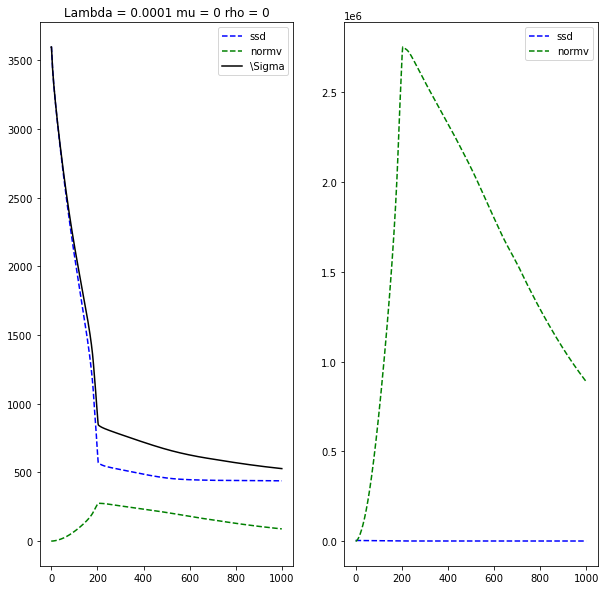

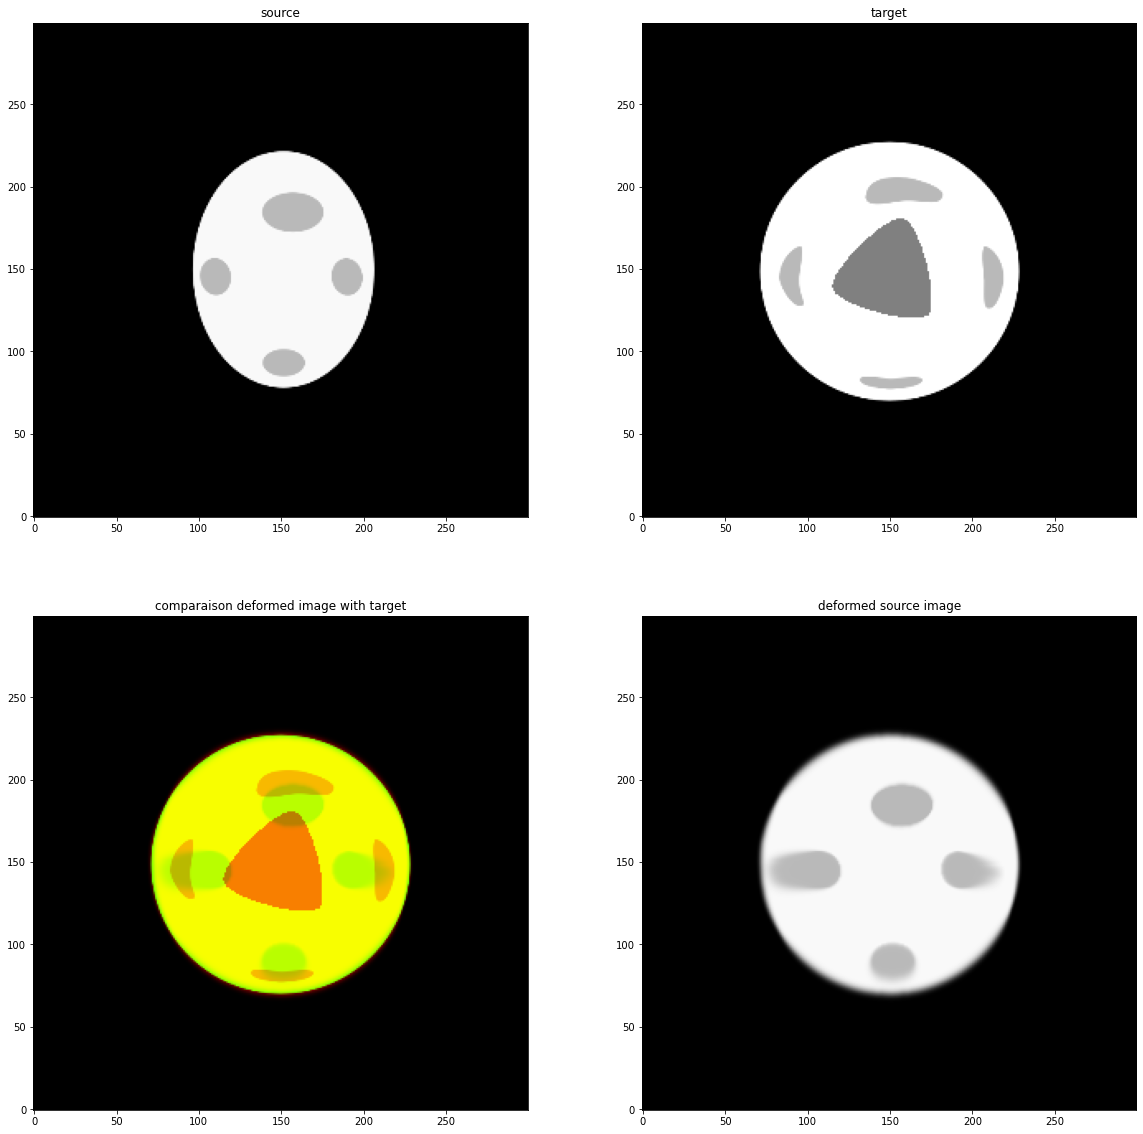

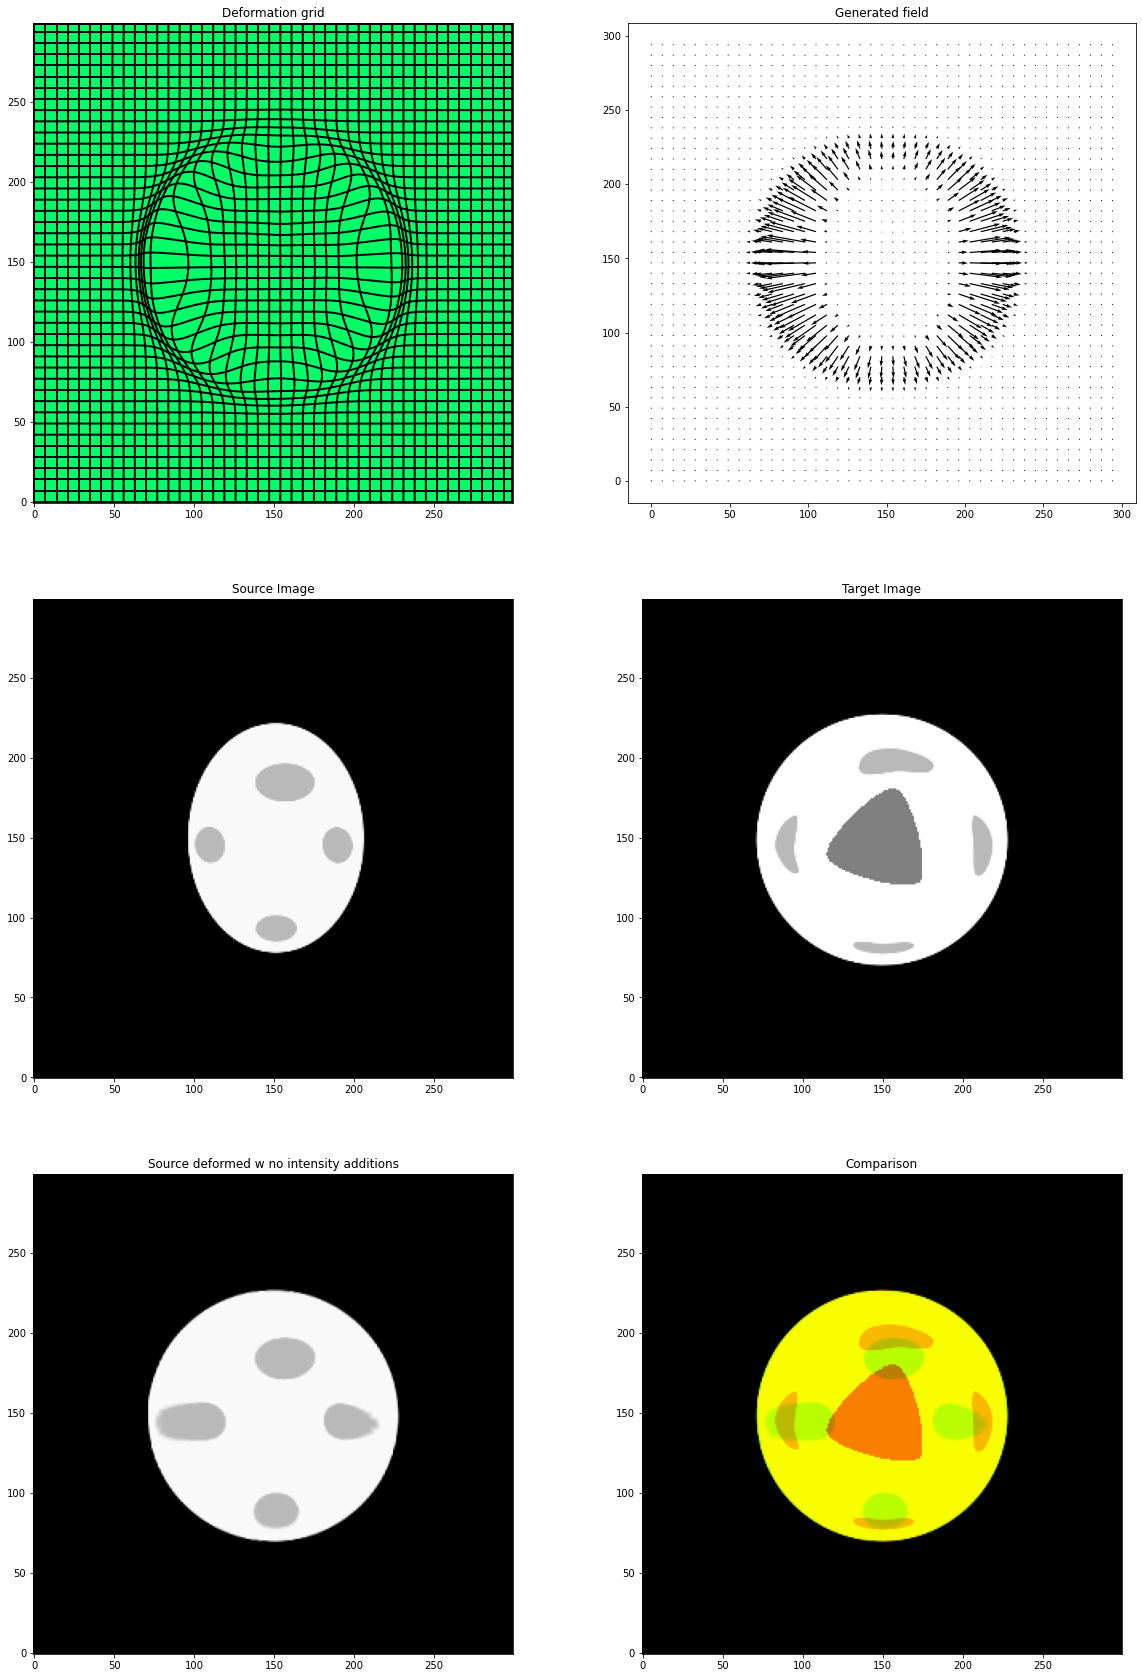

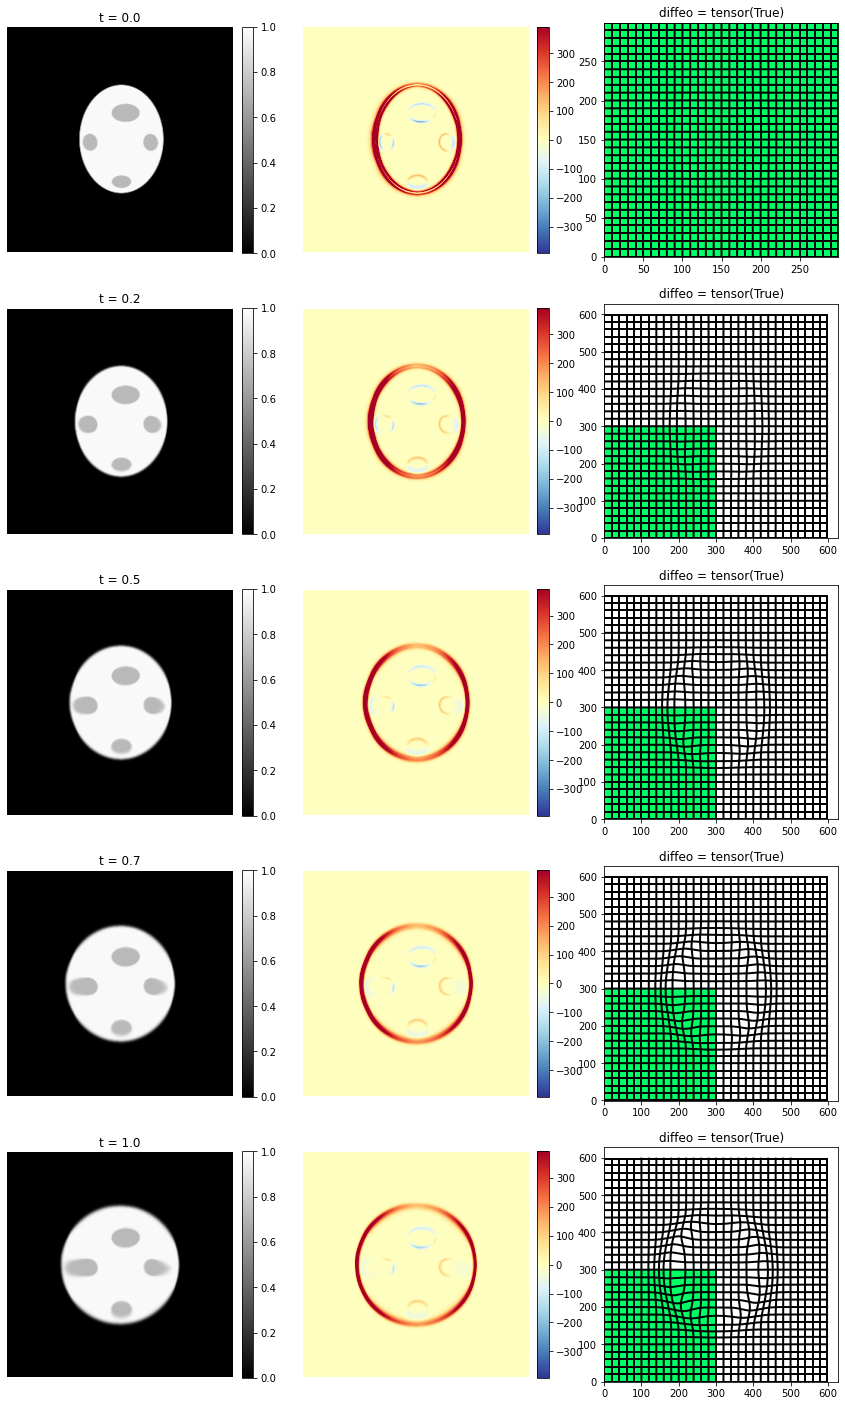

In [2]:
sigma,cost_cst = (9,.0001)
integration_step,n_iter,grad_coef = (20,1000,1000)
residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr_lddmm = mt.lddmm(source,target,residuals,sigma,cost_cst,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_lddmm.plot()
mr_lddmm.plot_deform()
mr_lddmm.mp.plot()

## 1.b Metamoprhosis

We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$


Progress: [##########] 100.00% Done...val ,   65.77).
 (cost_val ,   60.99).
Computation done in  0:00:55s and 0.816cents  s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 1080x1800 with 25 Axes>,
 array([[<AxesSubplot:title={'center':'t = 0.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.2'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.5'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.7'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 1.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>]],
       dtype=object))

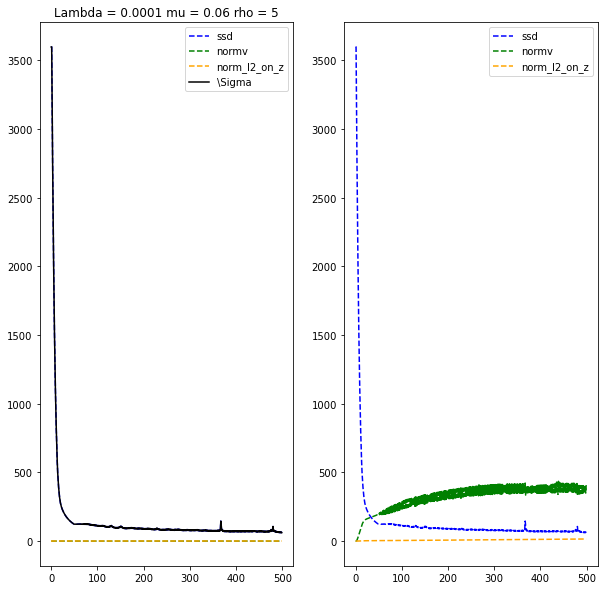

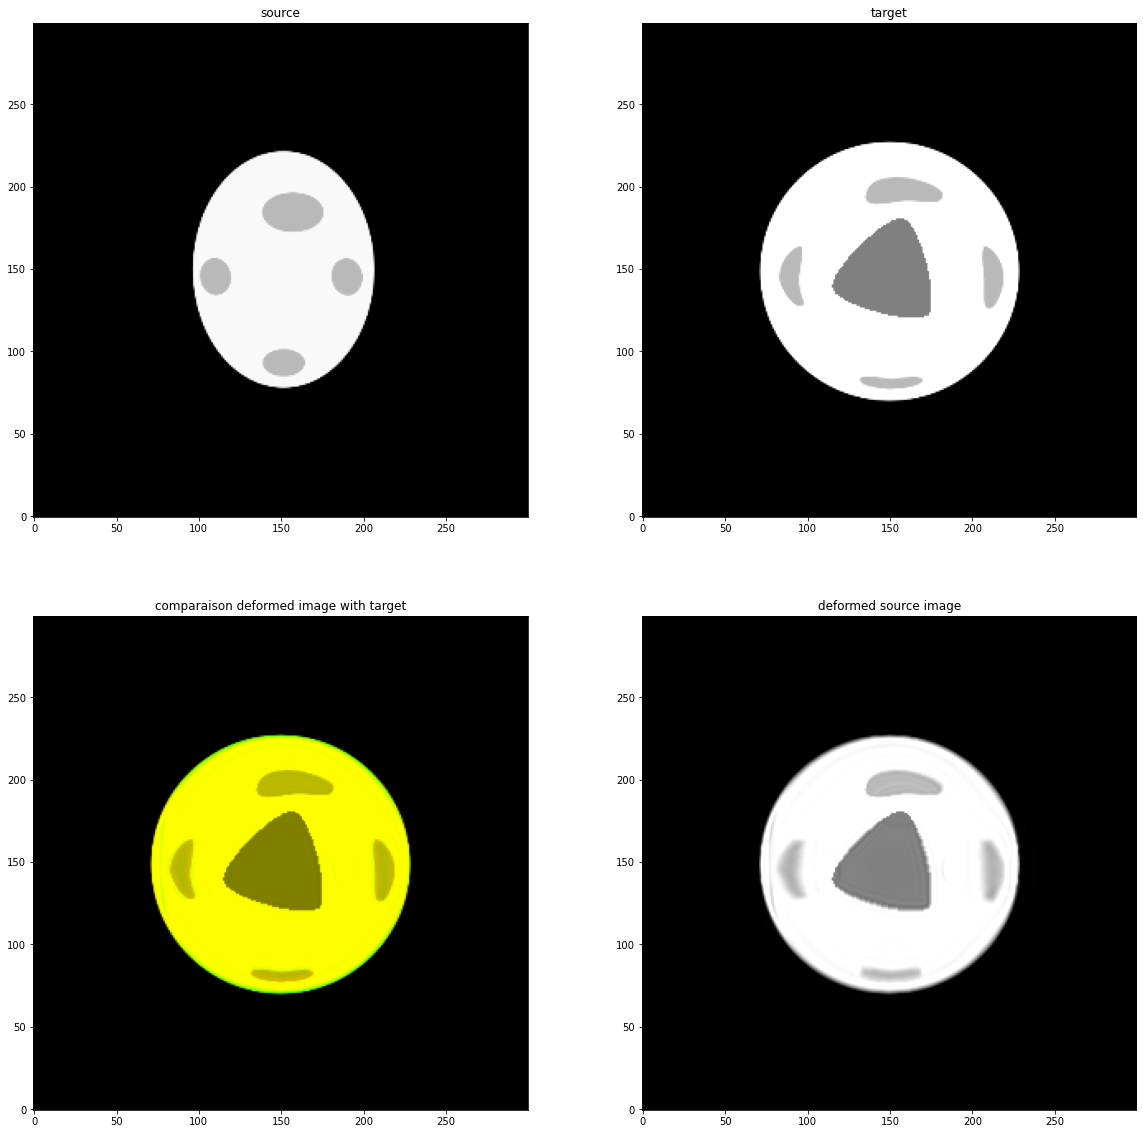

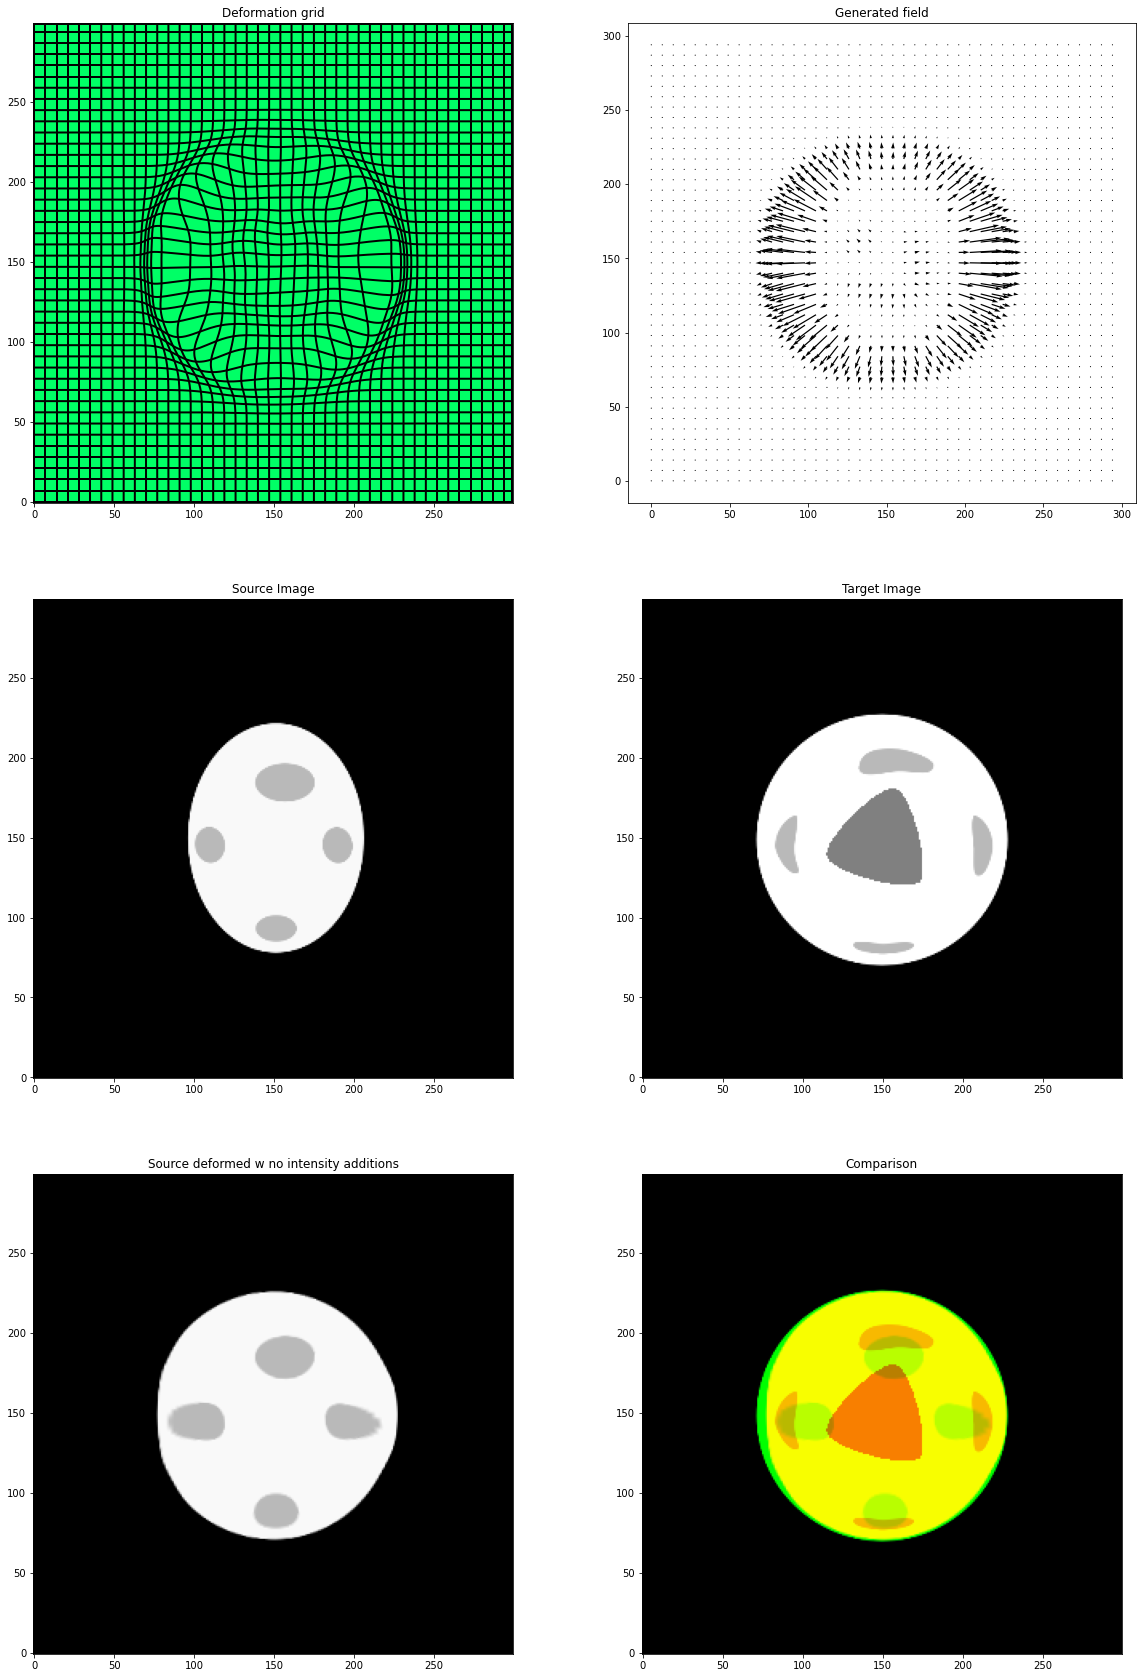

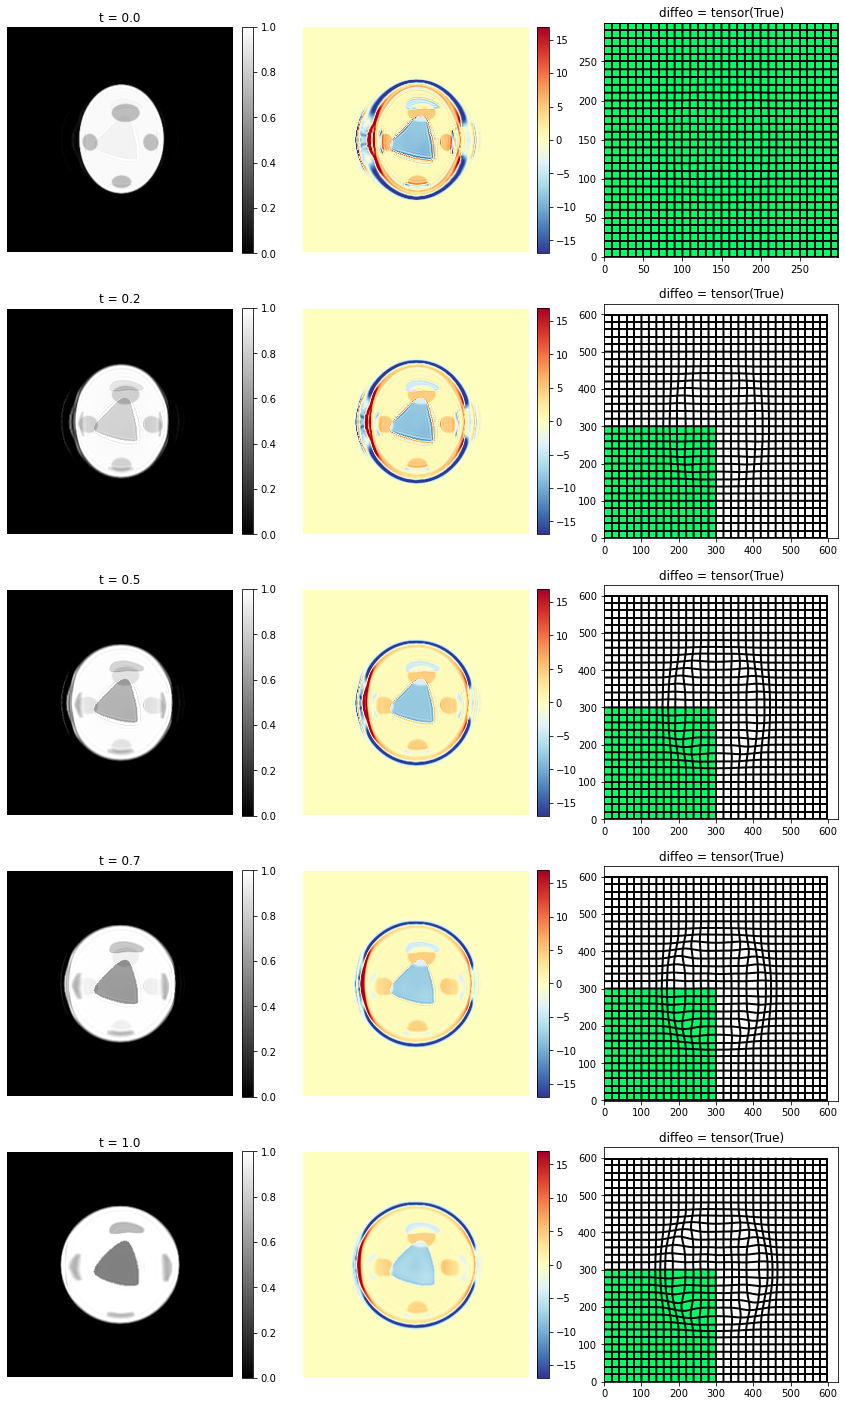

In [3]:
mu,rho,lamb,sigma = (.06,5,.0001,9)
integration_step,n_iter,grad_coef = (20,500,100)
residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr_meta = mt.metamorphosis(source,target,residuals,mu,rho,sigma,lamb,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_meta.plot()
mr_meta.plot_deform()
mr_meta.mp.plot()




# 2./ Weighted Metamorphoses.



## 2.a./ Weighted Metamorphosis with constant mask

In this sub-section we set $\forall t \in [0,1], M_t = M_1$ where $M_1$ is the segmentation mask.

We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|\sqrt{M_0}z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$


Progress: [##########] 100.00% Done...val ,  101.57).
 (cost_val ,   97.83).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


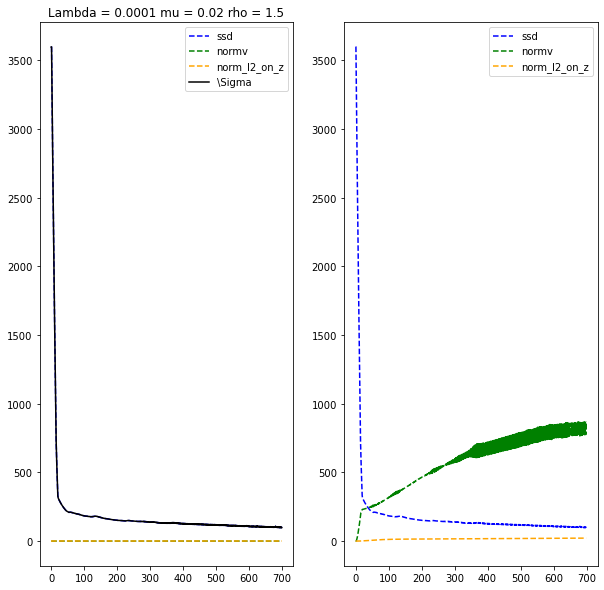

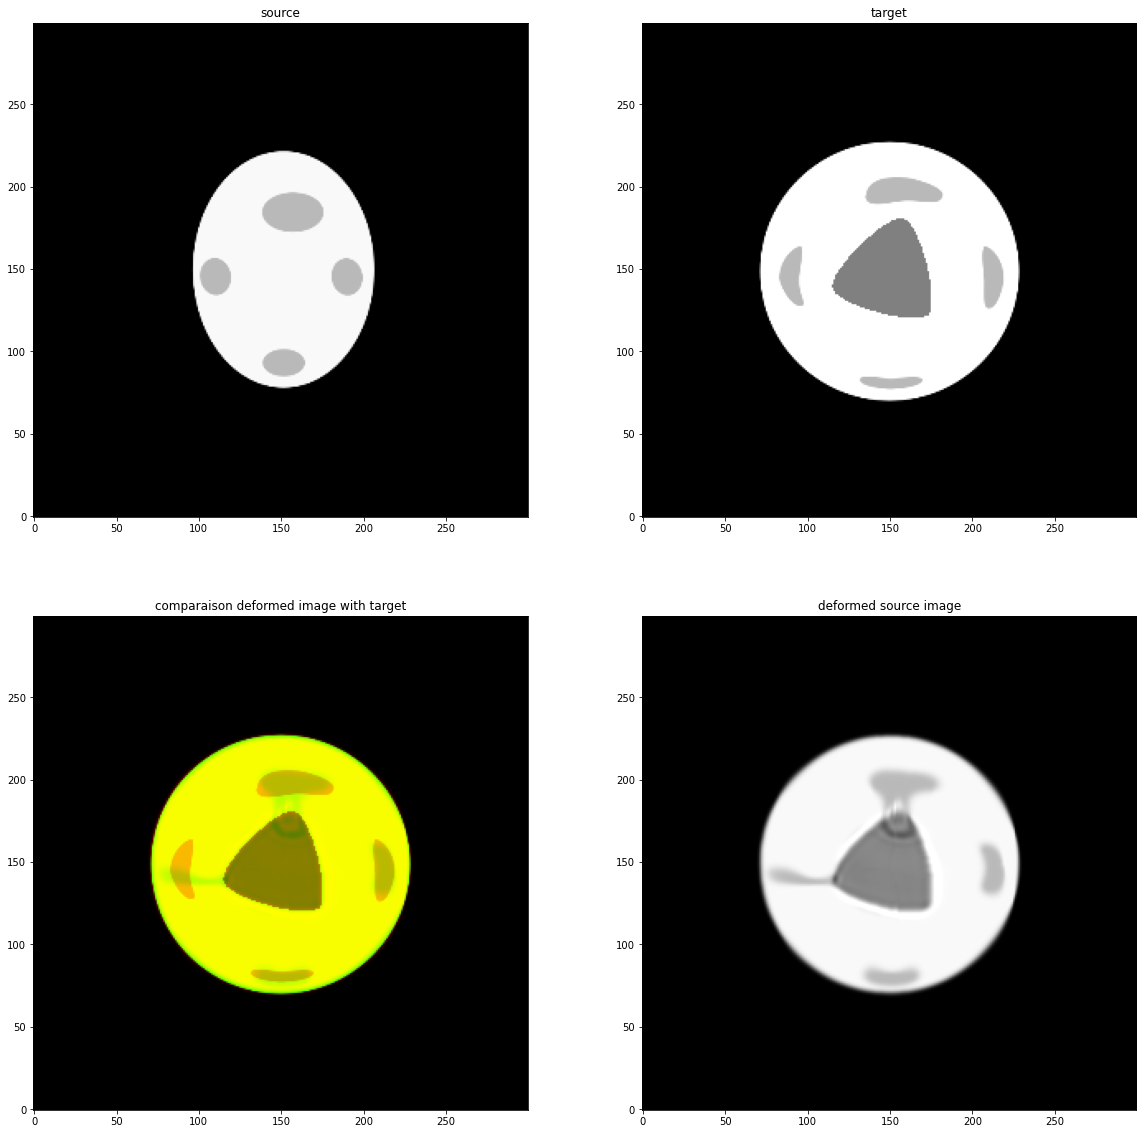

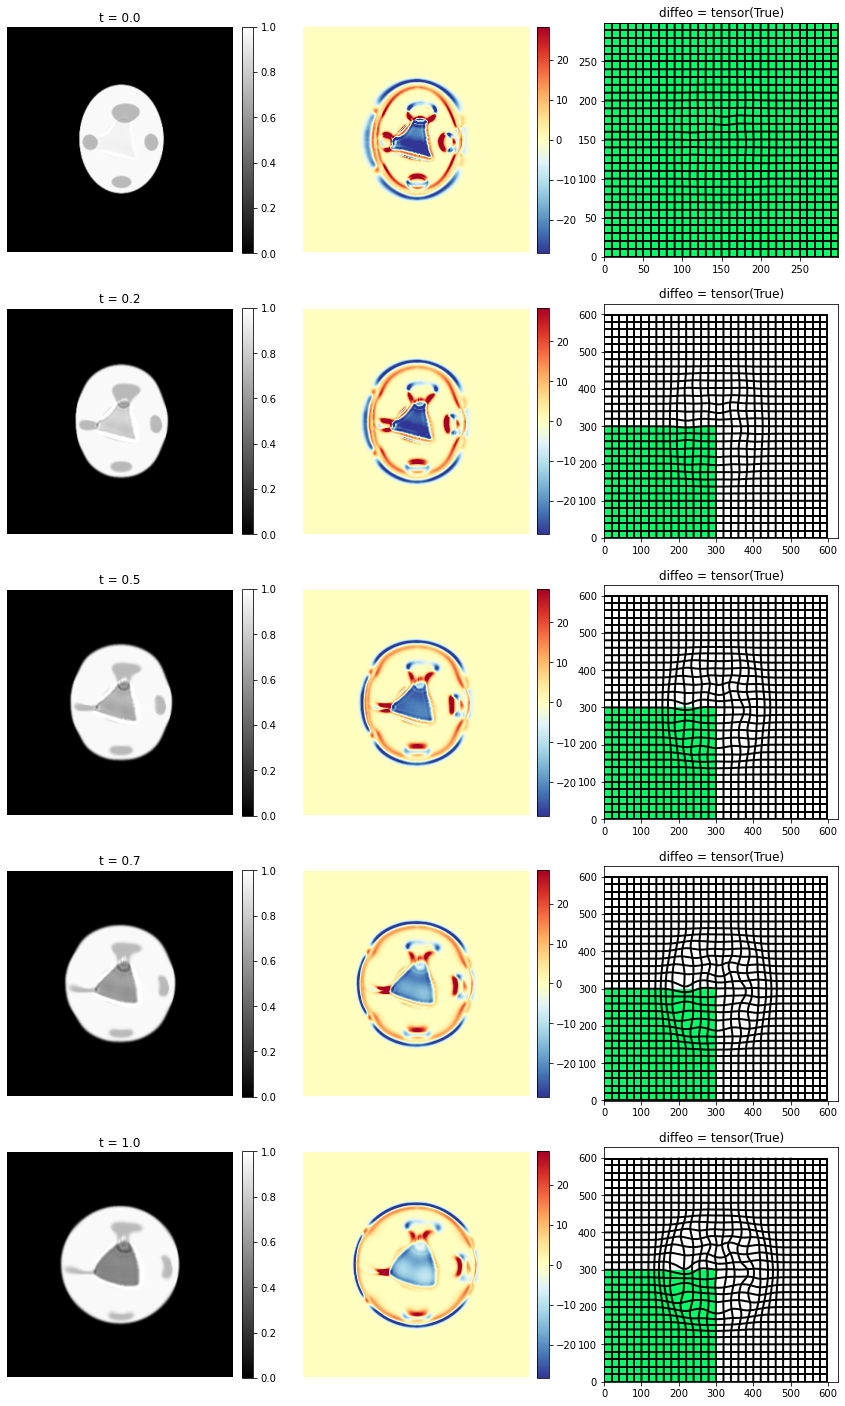

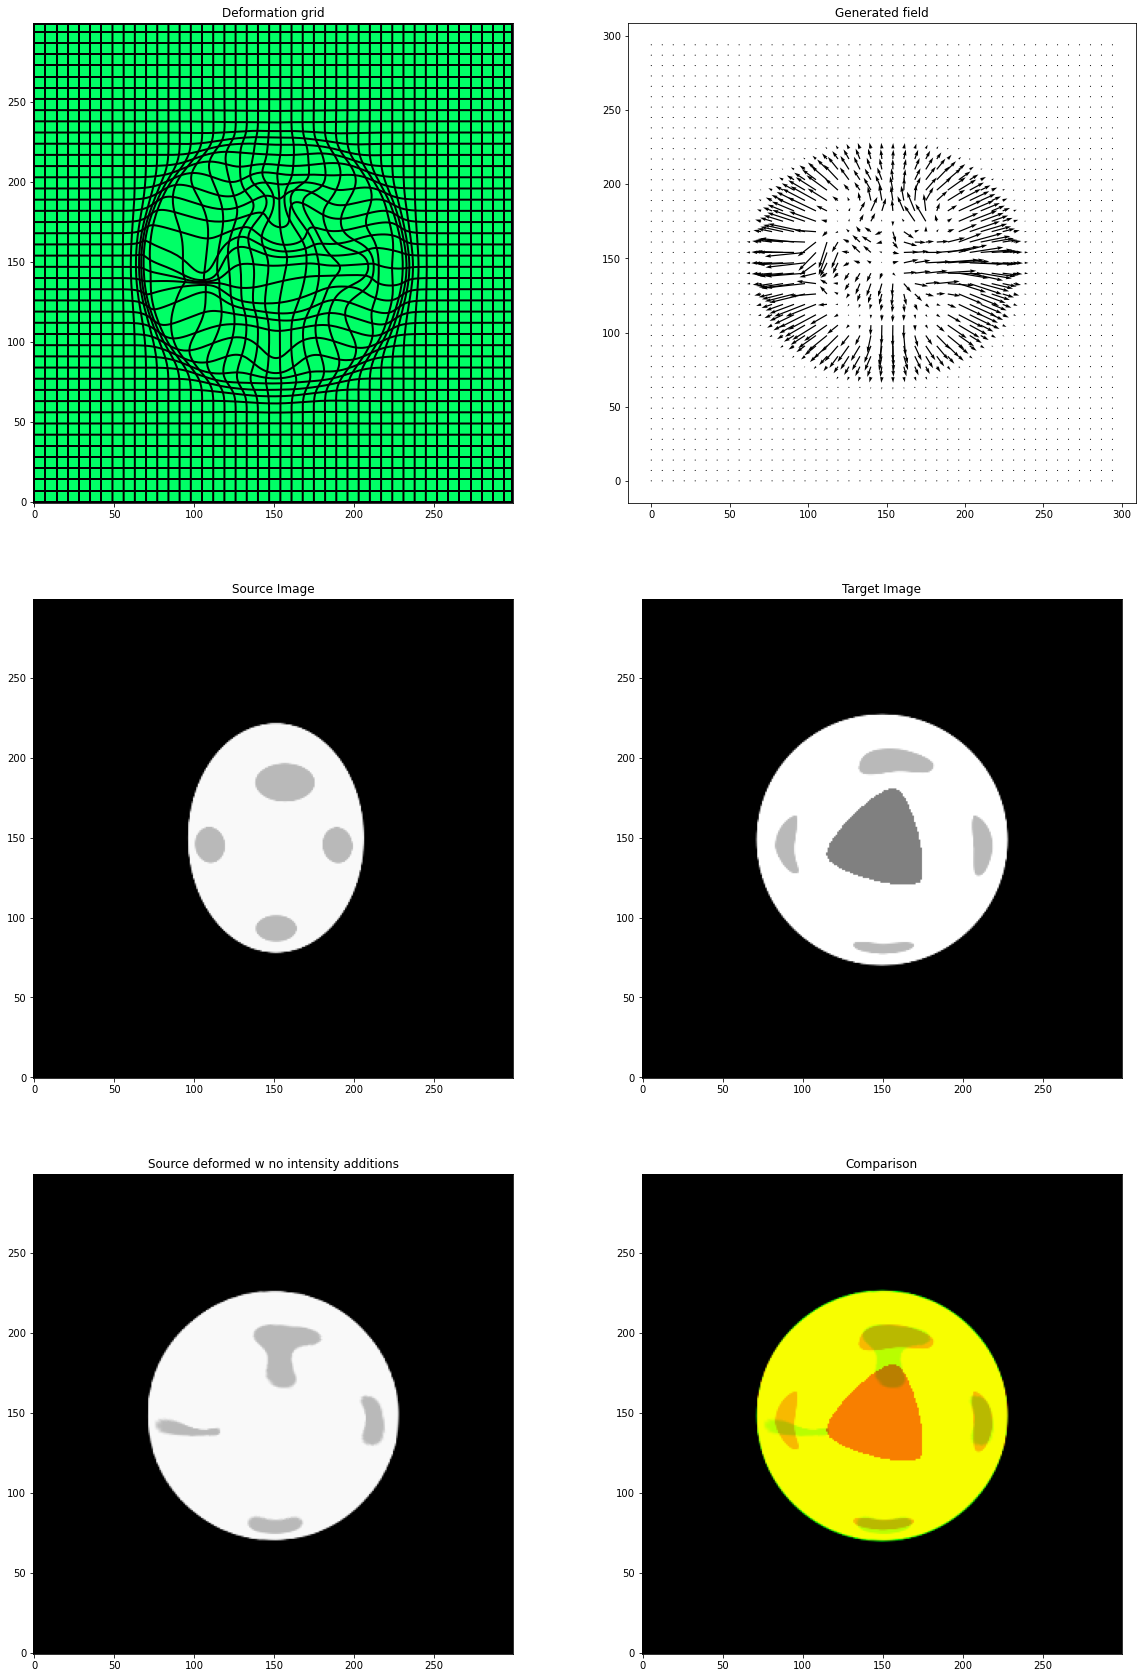

In [4]:

cst_mask = seg.repeat(20,1,1,1)
mu,rho,lamb,sigma = (.02,1.5,.0001,9)
n_iter,grad_coef = (700,100)
residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr_wm = mt.weighted_metamorphosis(source,target,residuals,cst_mask,
                    mu,rho,'identity',sigma,lamb,
                    n_iter,grad_coef,
                    safe_mode=False)

end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_wm.plot()
mr_wm.mp.plot()
mr_wm.plot_deform()

## 2.b./ Weighted Metamoprhosis with evolutive mask

First we need to compute the mask.

Progress: [##########] 100.00% Done...val ,   22.85).
 (cost_val ,   22.12).
Computation done in  0:00:17s and 0.587cents  s


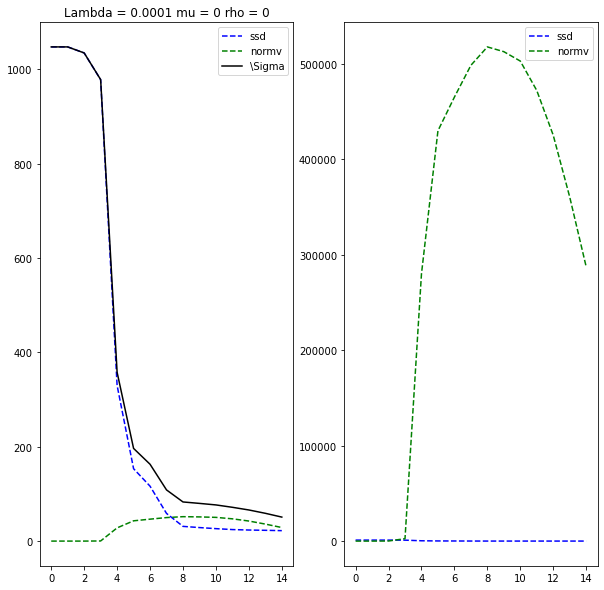

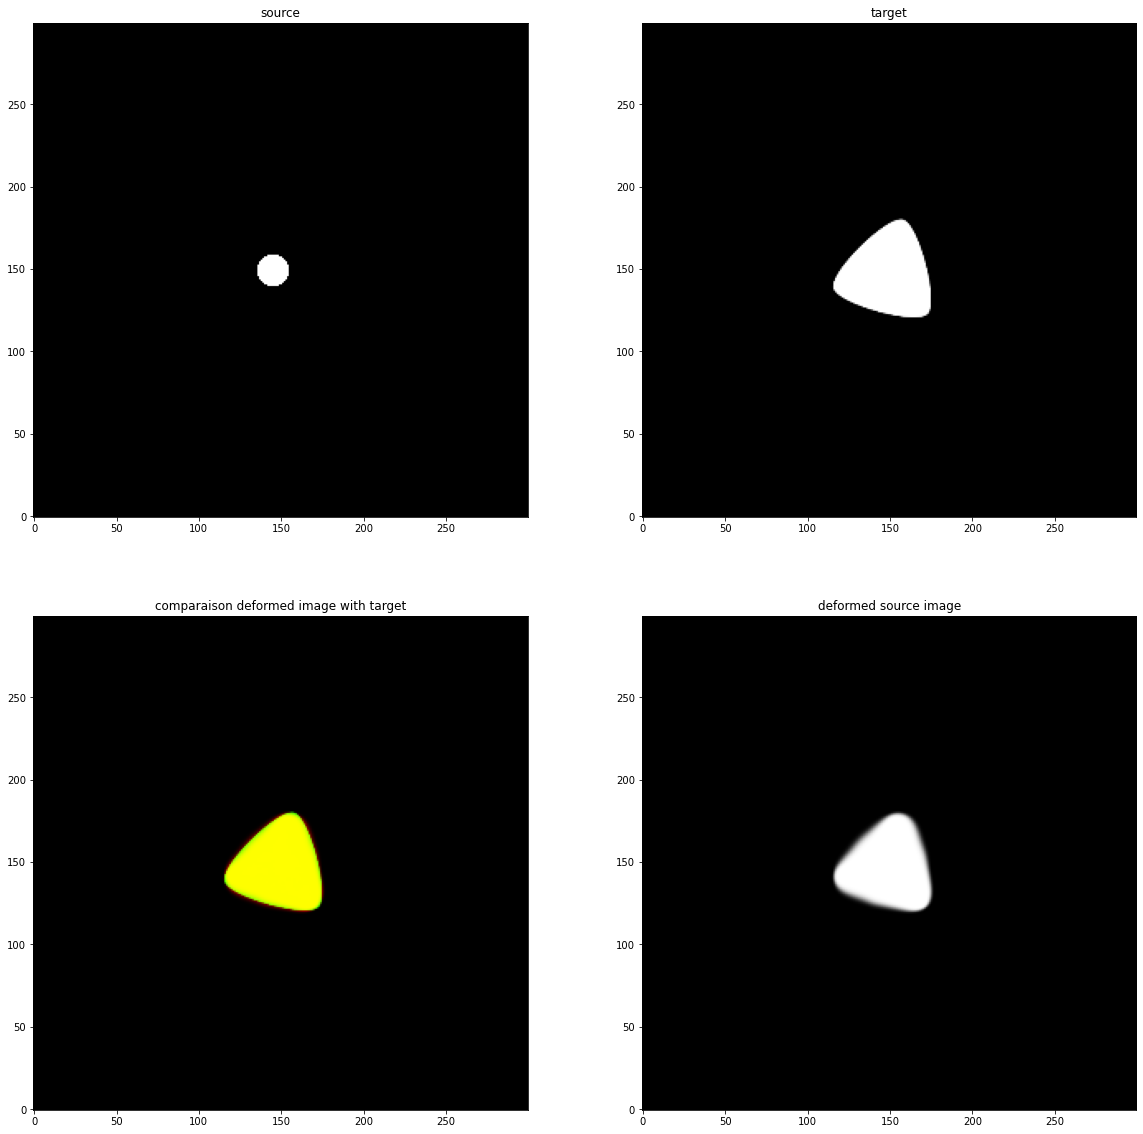

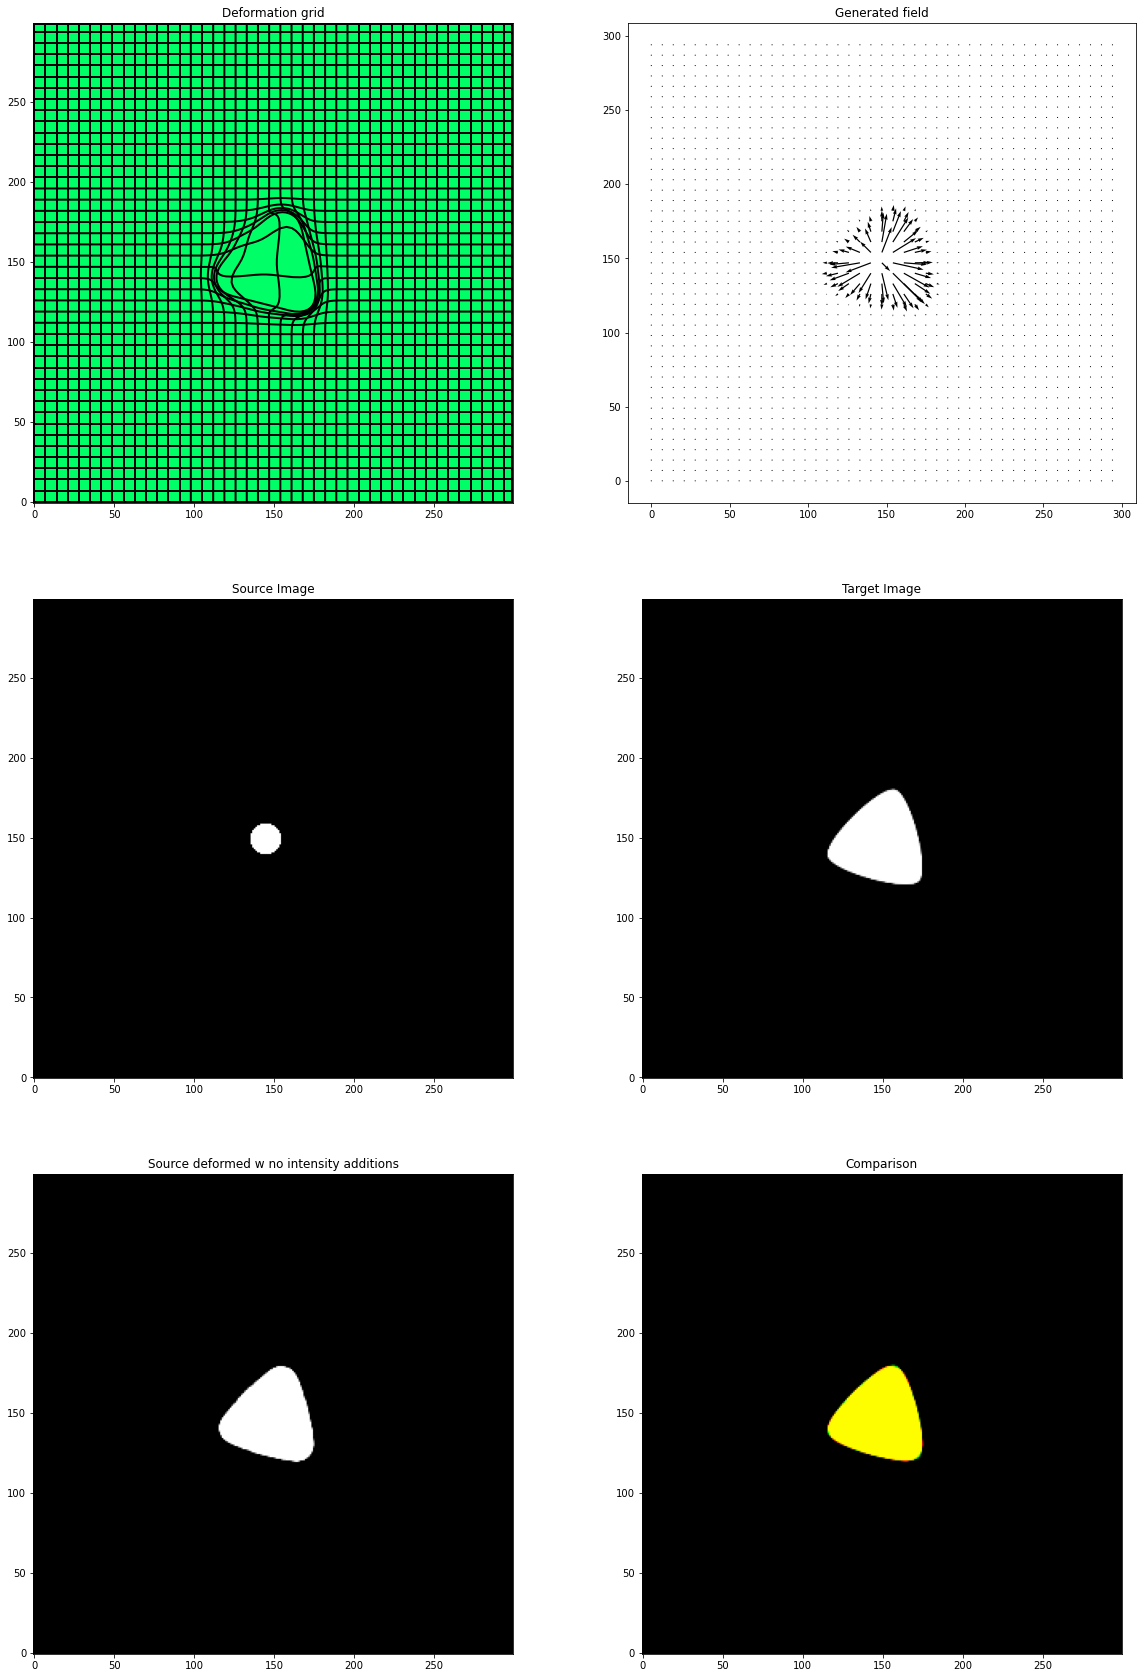

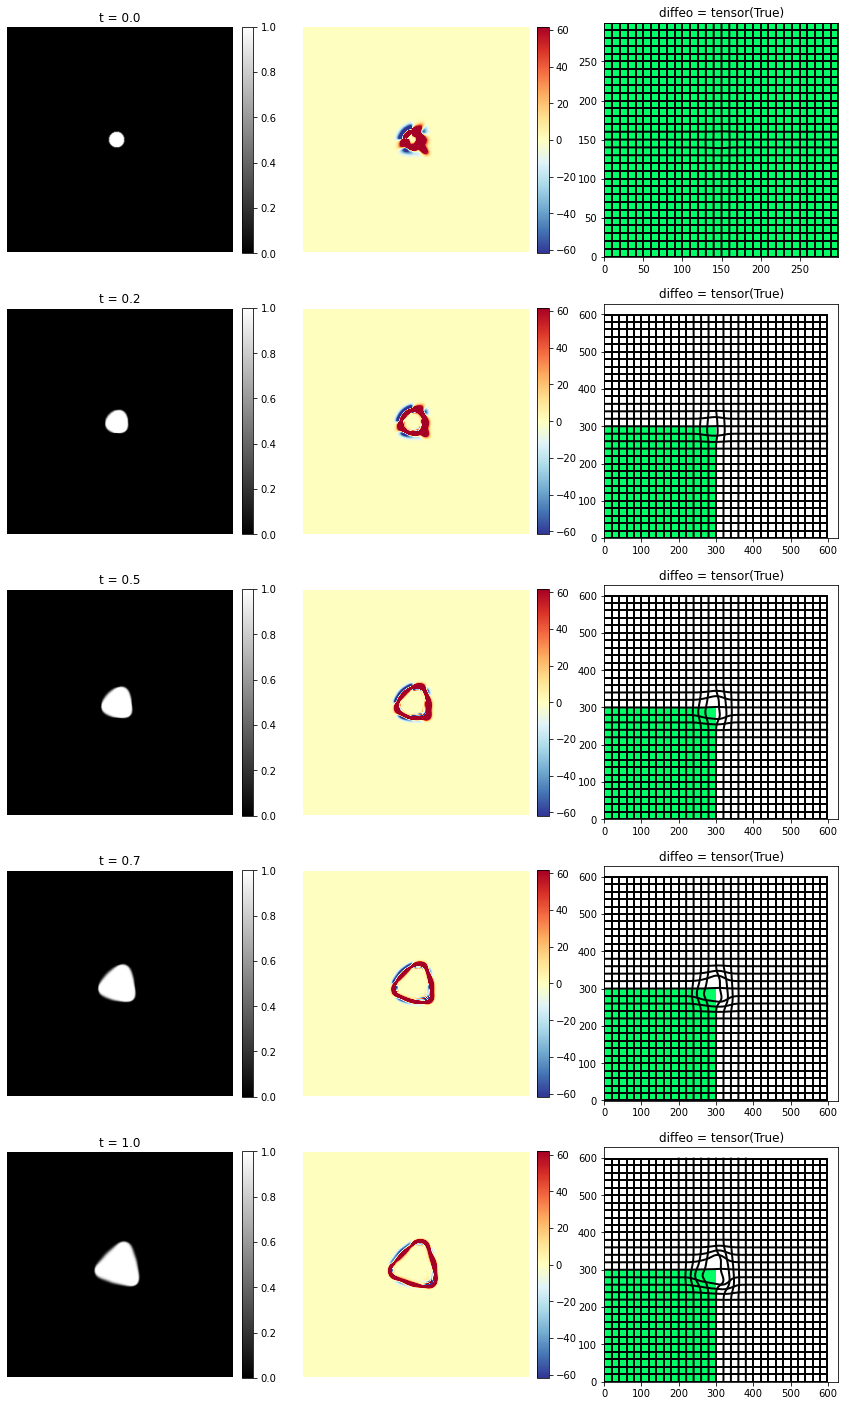

In [9]:


residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr = mt.lddmm(ini_ball,seg,residuals,7,.0001,
                    integration_steps=20,n_iter=15,grad_coef=.01,
                    optimizer_method='LBFGS_torch',safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr.plot()
mr.plot_deform()
mr.mp.plot()
mask = mr.mp.image_stock


The mask will be the successives images on the left column. 
We use the same parameters than the experiment with constant mask.

Progress: [##########] 100.00% Done...val ,   96.70).
 (cost_val ,   92.65).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


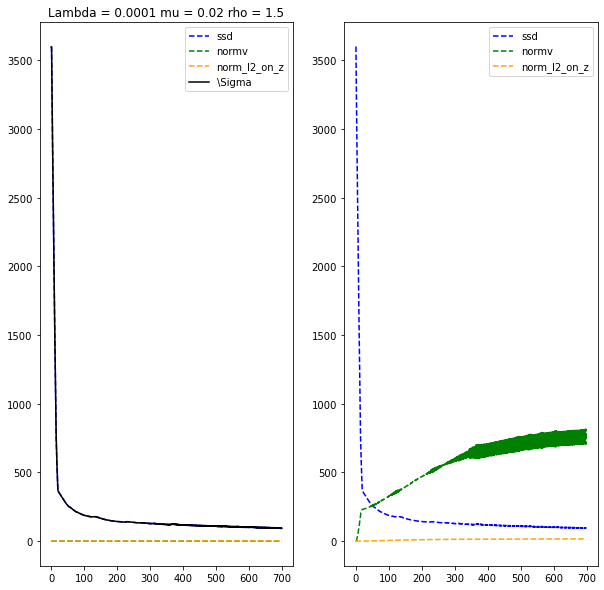

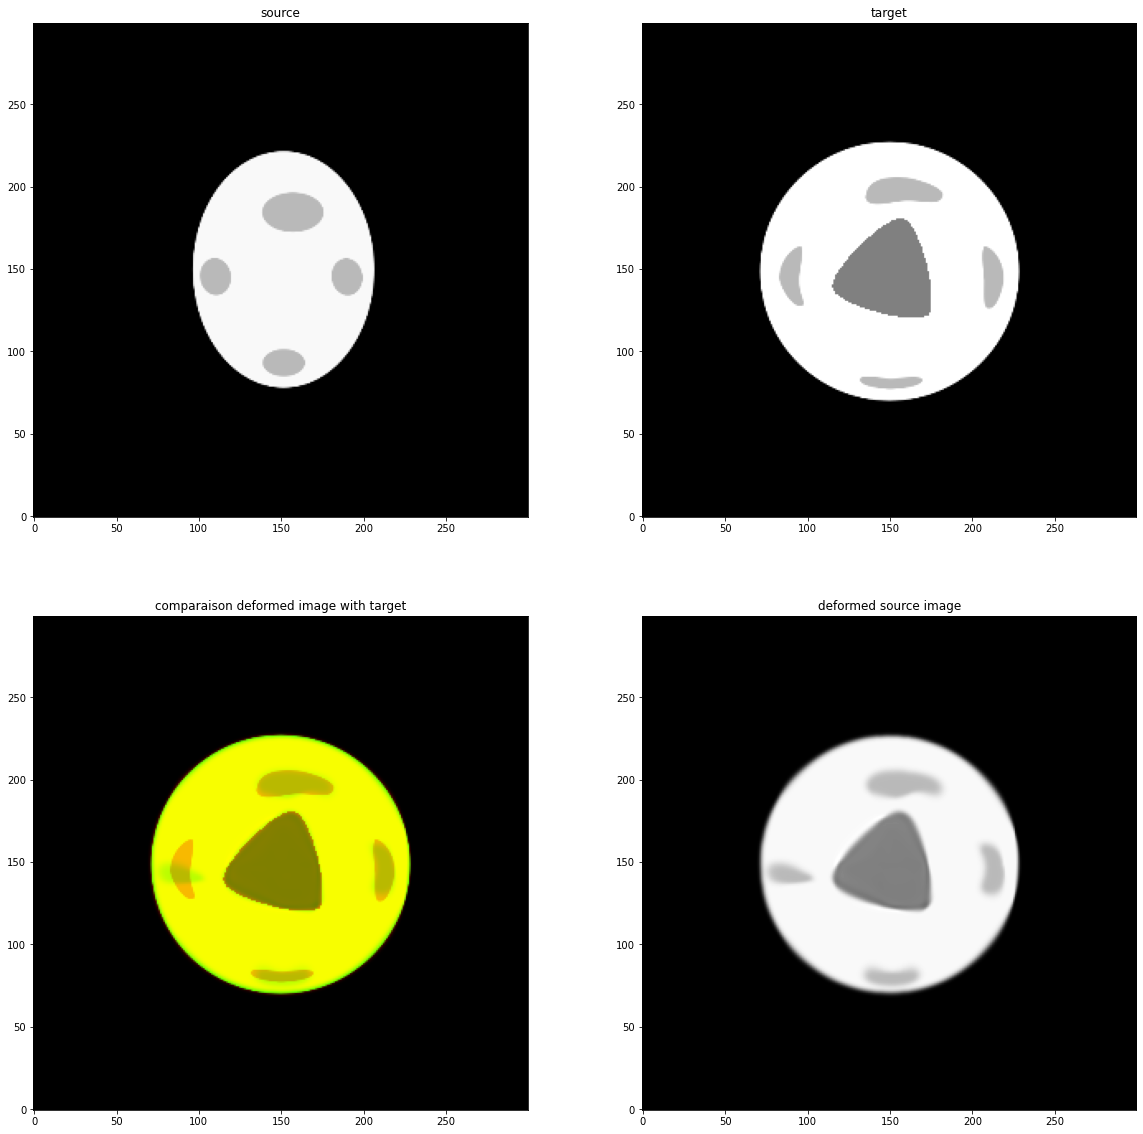

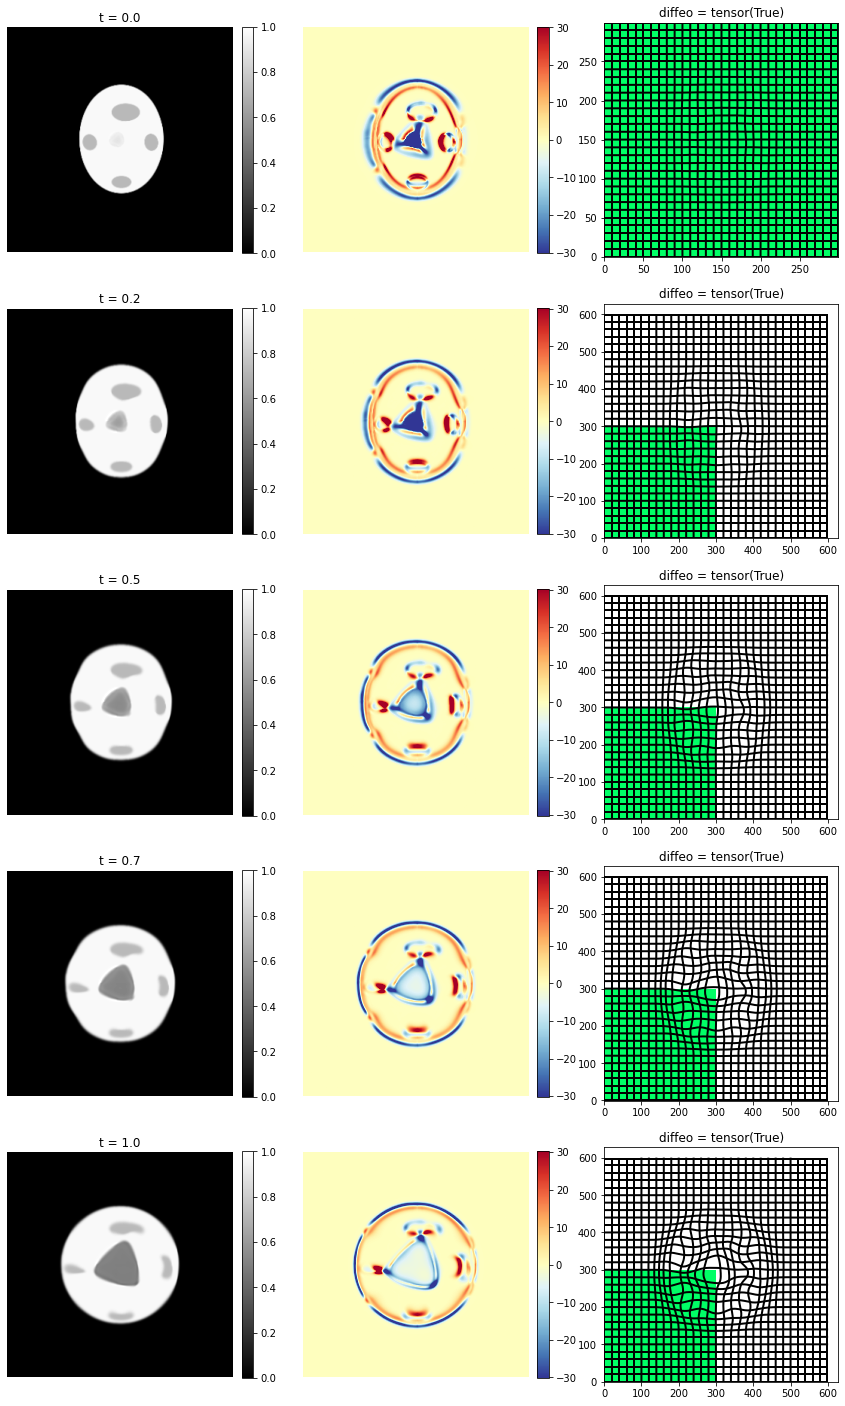

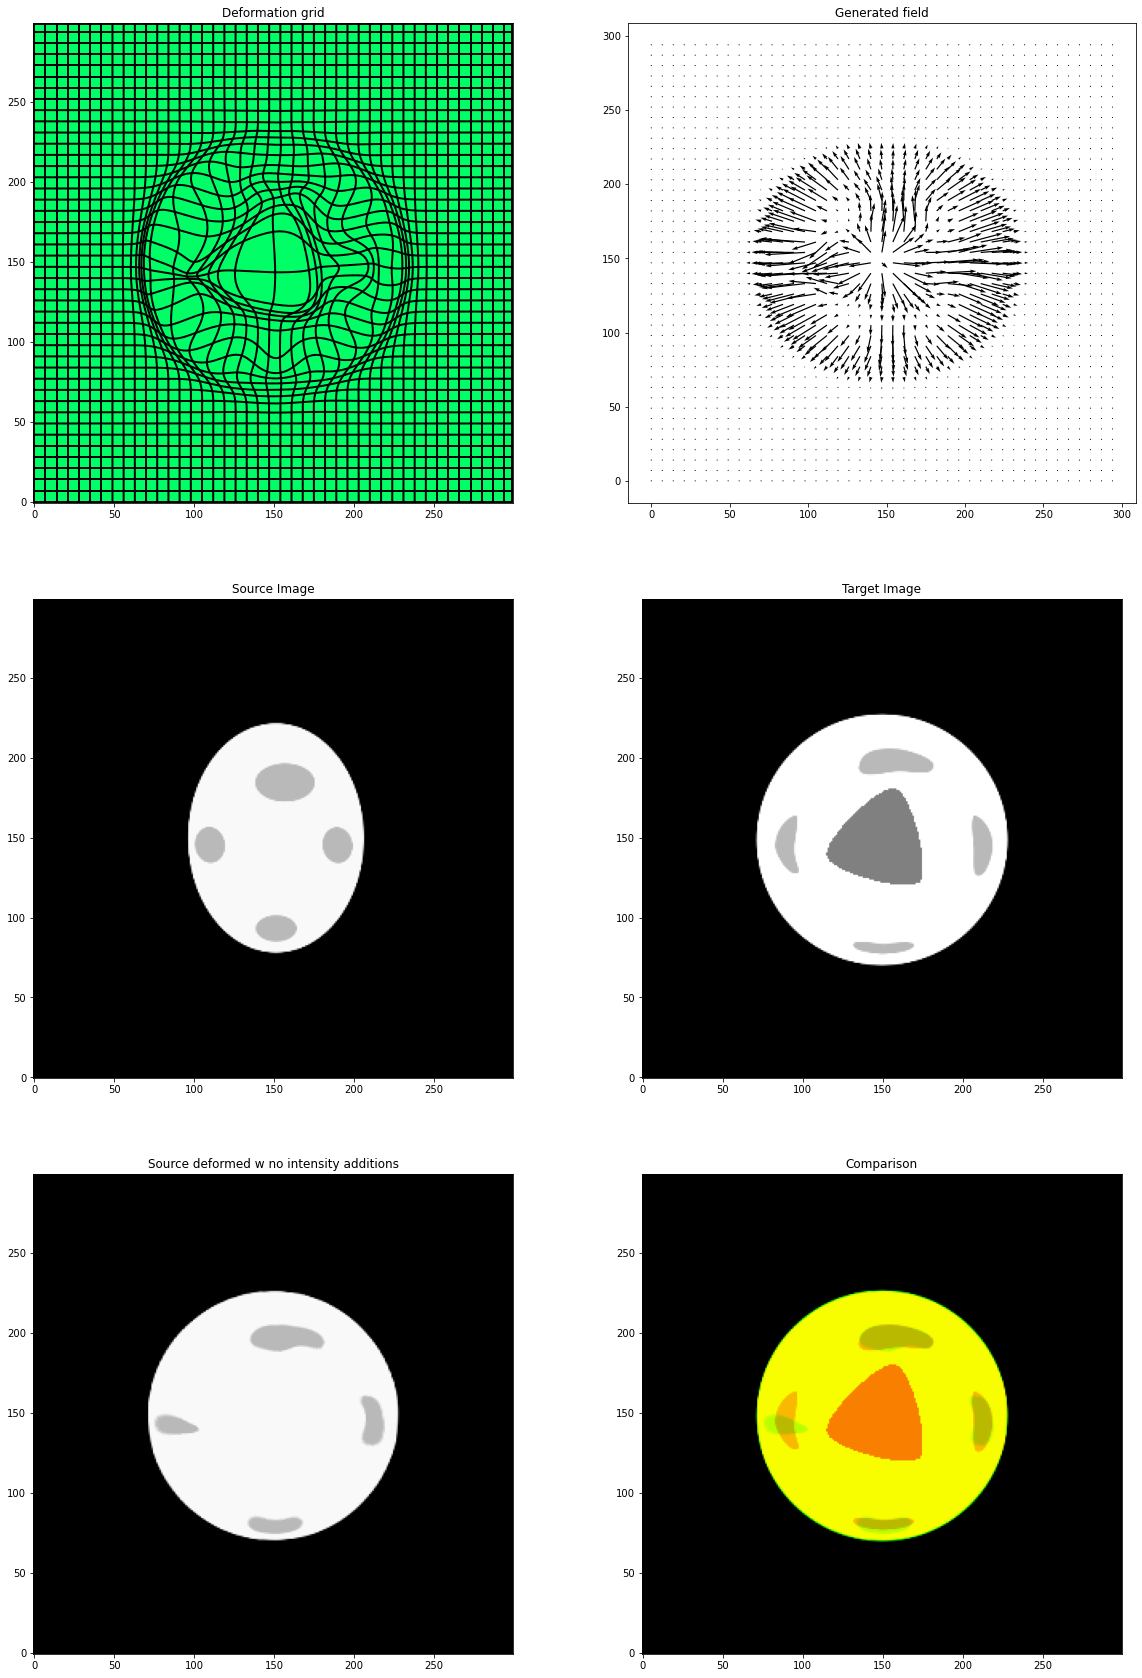

In [10]:
residuals = torch.zeros(source.shape[2:],device = device)

start = time.time()
mr_wm = mt.weighted_metamorphosis(source,target,residuals,mask,
                    mu,rho,'identity',sigma,lamb,
                    n_iter,grad_coef,
                    safe_mode=False)

end = time.time()
mr_wm.plot()
mr_wm.mp.plot()
mr_wm.plot_deform()